In [302]:
import os
import random
import pathlib
import splitfolders
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd
import cv2
from PIL import Image
import tensorflow as tf
import tensorflow.keras as keras
from keras import optimizers
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn import metrics

np.random.seed(1)

In [2]:
DATADIR = 'data/'
CATEGORIES = ['accordeon', 'dombyra', 'kobyz']

### Data Preprocessing

#### Cleaning the dataset

After I've manually cleaned up the data, this is what I'm left with:

In [6]:
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    print(f'{category}: {len(os.listdir(path))} images')

accordeon: 253 images
dombyra: 267 images
kobyz: 206 images


#### Renaming files

In [4]:
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for idx, name in enumerate(os.listdir(path)):
        dst = category + str(idx) + name[name.rfind('.'):]
        src = path + '/' + name
        dst = path + '/' + dst

        os.rename(src, dst)

I renamed each file to make all the data structured and kept its initial extension

In [7]:
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for idx, name in enumerate(os.listdir(path)):
        if idx >= 5:
            break
        else:
            print(name)

accordeon0.jpg
accordeon1.jpg
accordeon10.jpg
accordeon100.jfif
accordeon101.jfif
dombyra0.jpg
dombyra1.jpg
dombyra10.jpg
dombyra100.jfif
dombyra101.jfif
kobyz0.png
kobyz1.jpg
kobyz10.jpg
kobyz100.jfif
kobyz101.jfif


Here you can take a look at first 5 images from each folder

### Splitting images into train, val, test

#### Further on, I'm going to be running all tests on the data that's split using two different ratios.

In [93]:
# 80/20 Ratio
splitfolders.ratio(
    'data', output='input/80_20',
    seed=1337, ratio=(0.8, 0, 0.2)
)

Copying files: 722 files [00:01, 407.23 files/s]


In [95]:
# 70/30 Ratio
splitfolders.ratio(
    'data', output='input/70_30',
    seed=1337, ratio=(0.7, 0, 0.3)
)

Copying files: 722 files [00:04, 176.16 files/s]


In [97]:
# 80/20 Ratio
train_images_1, train_labels_1 = [], []
shape = (300, 300)
train_path_1 = 'input/80_20/train/'

for category in CATEGORIES:
    path = os.path.join(train_path_1, category)
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, shape)

        train_labels_1.append(category)
        train_images_1.append(img)

# Converting labels into One Hot encoded sparse matrix
train_labels_1 = pd.get_dummies(train_labels_1).values
# Converting train_images to array
train_images_1 = np.array(train_images_1)
# Splitting Training data into train and validation dataset
x_train_1, x_val_1, y_train_1, y_val_1 = train_test_split(
    train_images_1, train_labels_1, random_state=1
)

In [98]:
# 70/30 Ratio
train_images_2, train_labels_2 = [], []
shape = (300, 300)
train_path_2 = 'input/70_30/train/'

for category in CATEGORIES:
    path = os.path.join(train_path_2, category)
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, shape)

        train_labels_2.append(category)
        train_images_2.append(img)

# Converting labels into One Hot encoded sparse matrix
train_labels_2 = pd.get_dummies(train_labels_2).values
# Converting train_images to array
train_images_2 = np.array(train_images_2)
# Splitting Training data into train and validation dataset
x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(
    train_images_2, train_labels_2, random_state=1
)

In [99]:
# 80/20 Ratio
test_images_1, test_labels_1 = [], []
shape = (300, 300)
test_path_1 = 'input/80_20/test/'

for category in CATEGORIES:
    path = os.path.join(test_path_1, category)
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, shape)

        test_labels_1.append(category)
        test_images_1.append(img)

# Converting train_images to array
test_images_1 = np.array(test_images_1)

In [119]:
# 70/30 Ratio
test_images_2, test_labels_2 = [], []
shape = (300, 300)
test_path_2 = 'input/70_30/test/'

for category in CATEGORIES:
    path = os.path.join(test_path_2, category)
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, shape)

        test_labels_2.append(category)
        test_images_2.append(img)

# Converting train_images to array
test_images_2 = np.array(test_images_2)

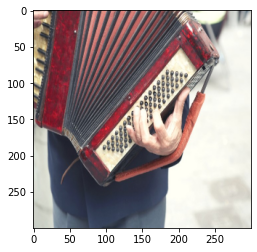

In [100]:
plt.imshow(train_images_1[0])

#### Exploratory Data Analysis

Since I've resized the data, for EDA I'm going to use the data from the initial folder (that hasn't been resized and split yet)

In [101]:
data = {
    'accordeon': [],
    'dombyra': [],
    'kobyz': []
}

Rearrange the data as a dict to make it structured and easy-to-access

In [102]:
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for filename in os.listdir(path):
        data[category].append(
            Image.open(os.path.join(path, filename))
        )

Mean, Std, Var, etc. values for heights and weights of each class

In [103]:
print('(width, height)\n')
for category in CATEGORIES:
    # path = os.path.join(DATADIR, category)
    widths = [img.size[0] for img in data[category]]
    heights = [img.size[1] for img in data[category]]

    min_ = (np.min(widths), np.min(heights))
    max_ = (np.max(widths), np.max(heights))
    mean = (round(np.mean(widths), 1), round(np.mean(heights), 1))
    med = (np.median(widths), np.median(heights))
    mode = (stats.mode(widths), stats.mode(heights))
    std = (round(np.std(widths), 1), round(np.std(heights), 1))
    var = (round(np.var(widths), 1), round(np.var(heights), 1))

    print(category)
    print(f'Min: {min_}')
    print(f'Max: {max_}')
    print(f'Mean: {mean}')
    print(f'Median: {med}')
    print(f'Mode: {mode}')
    print(f'Std: {std}')
    print(f'Variance: {var}\n')

(width, height)

accordeon
Min: (100, 100)
Max: (4472, 3240)
Mean: (418.1, 327.8)
Median: (259.0, 210.0)
Mode: (ModeResult(mode=array([225]), count=array([28])), ModeResult(mode=array([194]), count=array([28])))
Std: (477.5, 347.2)
Variance: (227976.8, 120569.3)

dombyra
Min: (100, 100)
Max: (4608, 3456)
Mean: (410.0, 383.5)
Median: (260.0, 225.0)
Mode: (ModeResult(mode=array([194]), count=array([24])), ModeResult(mode=array([194]), count=array([25])))
Std: (417.9, 430.3)
Variance: (174670.3, 185137.2)

kobyz
Min: (100, 100)
Max: (2486, 4085)
Mean: (379.7, 389.8)
Median: (259.0, 259.0)
Mode: (ModeResult(mode=array([100]), count=array([15])), ModeResult(mode=array([100]), count=array([15])))
Std: (348.9, 421.9)
Variance: (121726.3, 178004.1)



Pie chart below shows proportion of each class in the data

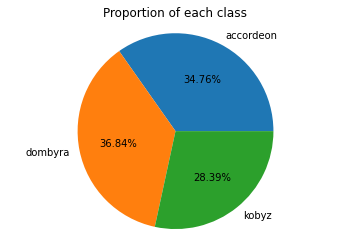

In [104]:
def pie_by_class():
    plt.pie(
        [len(data[category]) for category in CATEGORIES],
        explode=(0, 0, 0),
        labels=CATEGORIES,
        autopct='%1.2f%%'
    )
    plt.axis('equal')
    plt.title('Proportion of each class')
    plt.show()

pie_by_class()

A bar plotted below, gives more accurate view on number of images in each class

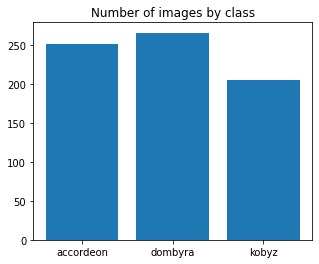

In [105]:
def bar_by_class():
    plt.figure(figsize=(5, 4))
    plt.bar(CATEGORIES, [len(data[category]) for category in CATEGORIES])
    plt.title('Number of images by class')
    plt.show()

bar_by_class()

Simple but useful function that plots random image

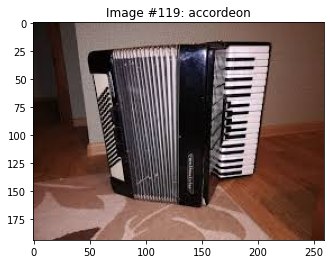

In [106]:
def plot_rand_img(category=''):
    category = (category, random.choice(CATEGORIES))[category == '']
    img = data[category][
        random.randrange(0, len(data[category]) - 1)
    ]
    plt.figure()
    plt.imshow(img)
    plt.title(f'Image #{data[category].index(img)}: {category}')
    plt.show()

plot_rand_img()

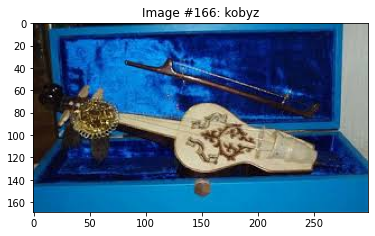

In [107]:
plot_rand_img('kobyz')

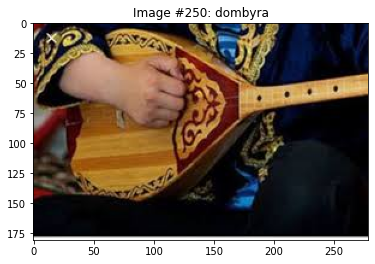

In [108]:
plot_rand_img('dombyra')

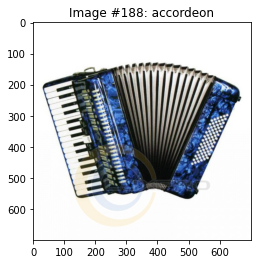

In [109]:
plot_rand_img('accordeon')

#### Histogram equalisation technique

It is a technique for adjusting the pixel values in an image to enhance the contrast by making those intensities more equal across the board. Typically, the histogram of an image will have something close to a normal distribution, but equalization aims for a uniform distribution.

Secondary functions:

In [110]:
# create our own histogram function
def get_hist(img, bins):
    # array with size of bins, set to zeros
    hist = np.zeros(bins)
    
    # loop through pixels and sum up counts of pixels
    for pixel in img:
        hist[pixel] += 1
    
    # return our final result
    return hist

In [111]:
# create our cumulative sum function
def cumsum(a):
    a = iter(a)
    b = [next(a)]

    for i in a:
        b.append(b[-1] + i)

    return np.array(b)

Step-by-step implementation:

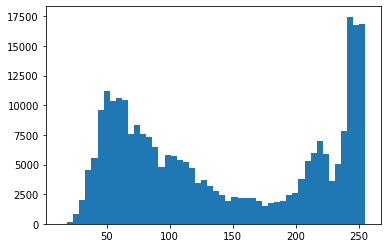

In [112]:
img = np.array(train_images_1[0])
flat = img.flatten()

# show the histogram
plt.hist(flat, bins=50)
plt.show()

In the flattened array, we have an intensity value for every pixel. The values will range from 0 (black) to 255 (white). Everything in between can be considered a shade of gray.

We can now take our one-dimensional array and compute the histogram for the image based on the frequency of similar intensity values. And I'm going to do that using the function I implemented above:

In [113]:
# execute our histogram function
hist = get_hist(flat, 256)

Cumulative sum is the sum of all values in the histogram up to that point, taking into account all previous values.

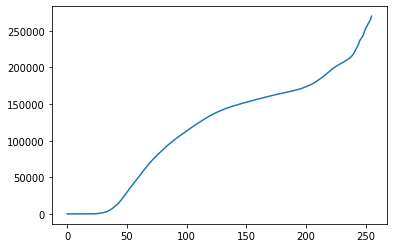

In [114]:
# execute the function
cs = cumsum(hist)
# display the result
plt.plot(cs)

Now, we're going to need to normalise this to a range of 0-255, as in the original image.

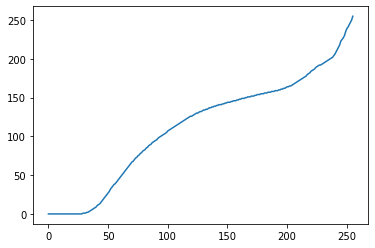

In [115]:
# numerator & denomenator
nj = (cs - cs.min()) * 255
N = cs.max() - cs.min()

# re-normalize the cumsum
cs = nj / N

# cast it back to uint8 since we can't use floating point values in images
cs = cs.astype('uint8')

plt.plot(cs)

We can now use the normalized cumulative sum to modify the intensity values of our original image. Basically, we’ll take all of the values from the flat array and use it as the index to look up related value in the cs array. The result becomes the new intensity value which will be stored in img_new for that particular pixel.

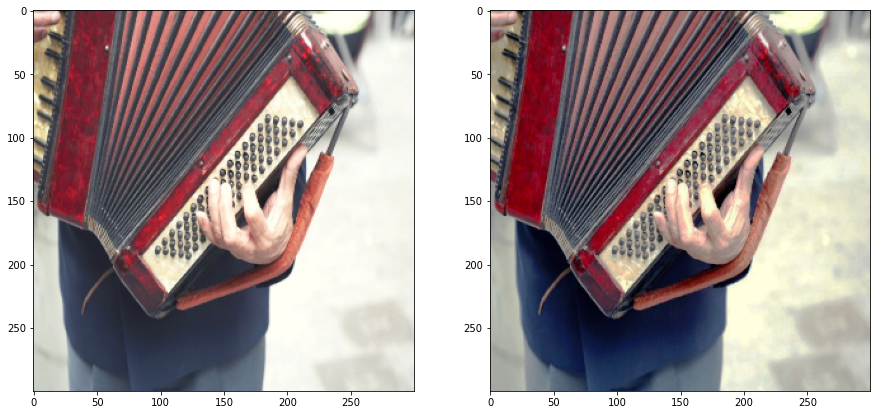

In [116]:
# get the value from cumulative sum for every index in flat, and set that as img_new
img_new = cs[flat]

# put array back into original shape since we flattened it
img_new = np.reshape(img_new, img.shape)

# set up side-by-side image display
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

fig.add_subplot(1, 2, 1)
plt.imshow(img)

# display the new image
fig.add_subplot(1, 2, 2)
plt.imshow(img_new)

plt.show(block=True)

Main function:

In [117]:
def hist_eq(img):
    flat = img.flatten()
    # execute our histogram function
    hist = get_hist(flat, 256)
    # calculate the cumsum
    cs = cumsum(hist)
    # numerator & denomenator
    nj = (cs - cs.min()) * 255
    N = cs.max() - cs.min()
    # re-normalize the cumsum
    cs = nj / N
    # cast it back to uint8 since we can't use floating point values in images
    cs = cs.astype('uint8')
    # get the value from cumulative sum for every index in flat, and set that as img_new
    img_new = cs[flat]
    # put array back into original shape since we flattened it
    img_new = np.reshape(img_new, img.shape)

    return img_new

Applying histogram equalisation to each image:

In [120]:
# 80/20 Ratio
x_train_1_hist = x_train_1.copy()
x_val_1_hist = x_val_1.copy()
test_images_1_hist = test_images_1.copy()

for idx in range(x_train_1_hist.shape[0]):
    x_train_1_hist[idx] = hist_eq(x_train_1_hist[idx])

for idx in range(x_val_1_hist.shape[0]):
    x_val_1_hist[idx] = hist_eq(x_val_1_hist[idx])

for idx in range(test_images_1_hist.shape[0]):
    test_images_1_hist[idx] = hist_eq(test_images_1_hist[idx])

In [121]:
# 70/30 Ratio
x_train_2_hist = x_train_2.copy()
x_val_2_hist = x_val_2.copy()
test_images_2_hist = test_images_2.copy()

for idx in range(x_train_2_hist.shape[0]):
    x_train_2_hist[idx] = hist_eq(x_train_2_hist[idx])

for idx in range(x_val_2_hist.shape[0]):
    x_val_2_hist[idx] = hist_eq(x_val_2_hist[idx])

for idx in range(test_images_2_hist.shape[0]):
    test_images_2_hist[idx] = hist_eq(test_images_2_hist[idx])

### Creating a Model

#### This is the model that I have come up with after making multiple simulations

In [130]:
model = Sequential()
model.add(Flatten(input_shape=(300, 300, 3)))
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=['acc']
)

#### Model Summary

In [131]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 270000)            0         
_________________________________________________________________
dense_61 (Dense)             (None, 100)               27000100  
_________________________________________________________________
dropout_31 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_32 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 3)                 153       
Total params: 27,005,303
Trainable params: 27,005,303
Non-trainable params: 0
_________________________________________

### Training the model

#### 80/20 Ratio, Raw data

In [132]:
history_raw_1 = model.fit(
    x_train_1, y_train_1,
    epochs=100, batch_size=100,
    validation_data=(x_val_1, y_val_1)
)

Epoch 1/100
5/5 [==============================] - 5s 831ms/step - loss: 8474.8142 - acc: 0.2947 - val_loss: 2933.2795 - val_acc: 0.3333
Epoch 2/100
5/5 [==============================] - 2s 446ms/step - loss: 4009.2402 - acc: 0.4138 - val_loss: 1068.0115 - val_acc: 0.3611
Epoch 3/100
5/5 [==============================] - 2s 443ms/step - loss: 3478.9819 - acc: 0.3784 - val_loss: 4297.7612 - val_acc: 0.3333
Epoch 4/100
5/5 [==============================] - 2s 442ms/step - loss: 2702.1795 - acc: 0.4538 - val_loss: 5648.9390 - val_acc: 0.3194
Epoch 5/100
5/5 [==============================] - 2s 456ms/step - loss: 5504.4782 - acc: 0.3582 - val_loss: 639.9146 - val_acc: 0.5625
Epoch 6/100
5/5 [==============================] - 2s 446ms/step - loss: 1833.2381 - acc: 0.5015 - val_loss: 1132.4738 - val_acc: 0.4722
Epoch 7/100
5/5 [==============================] - 2s 442ms/step - loss: 2116.0664 - acc: 0.4427 - val_loss: 2922.4067 - val_acc: 0.5347
Epoch 8/100
5/5 [=========================

5/5 [==============================] - 2s 436ms/step - loss: 1363.1119 - acc: 0.6649 - val_loss: 1166.7441 - val_acc: 0.6250
Epoch 61/100
5/5 [==============================] - 2s 433ms/step - loss: 1545.0020 - acc: 0.5742 - val_loss: 787.4177 - val_acc: 0.6111
Epoch 62/100
5/5 [==============================] - 2s 437ms/step - loss: 1964.9615 - acc: 0.5634 - val_loss: 1537.8354 - val_acc: 0.6181
Epoch 63/100
5/5 [==============================] - 2s 435ms/step - loss: 1460.0431 - acc: 0.6834 - val_loss: 635.4730 - val_acc: 0.6875
Epoch 64/100
5/5 [==============================] - 2s 438ms/step - loss: 1052.8291 - acc: 0.6531 - val_loss: 1076.9509 - val_acc: 0.5764
Epoch 65/100
5/5 [==============================] - 2s 452ms/step - loss: 1451.2487 - acc: 0.6366 - val_loss: 2496.5850 - val_acc: 0.5764
Epoch 66/100
5/5 [==============================] - 2s 434ms/step - loss: 1734.6141 - acc: 0.5919 - val_loss: 1421.6097 - val_acc: 0.5625
Epoch 67/100
5/5 [==============================]

#### 80/20 Ratio, History Equalisation

In [133]:
history_1_hist = model.fit(
    x_train_1_hist, y_train_1,
    epochs=100, batch_size=100,
    validation_data=(x_val_1_hist, y_val_1)
)

Epoch 1/100
5/5 [==============================] - 2s 455ms/step - loss: 694.2630 - acc: 0.7384 - val_loss: 2330.5364 - val_acc: 0.5764
Epoch 2/100
5/5 [==============================] - 2s 449ms/step - loss: 873.1685 - acc: 0.7106 - val_loss: 867.6685 - val_acc: 0.6667
Epoch 3/100
5/5 [==============================] - 2s 433ms/step - loss: 1298.9182 - acc: 0.6481 - val_loss: 869.9633 - val_acc: 0.6736
Epoch 4/100
5/5 [==============================] - 2s 439ms/step - loss: 1778.4833 - acc: 0.6204 - val_loss: 1042.3009 - val_acc: 0.6458
Epoch 5/100
5/5 [==============================] - 2s 437ms/step - loss: 1228.0709 - acc: 0.6088 - val_loss: 827.6523 - val_acc: 0.6528
Epoch 6/100
5/5 [==============================] - 2s 440ms/step - loss: 1087.1078 - acc: 0.6528 - val_loss: 937.9177 - val_acc: 0.6111
Epoch 7/100
5/5 [==============================] - 2s 432ms/step - loss: 1039.8081 - acc: 0.6528 - val_loss: 1264.6278 - val_acc: 0.6389
Epoch 8/100
5/5 [==============================

Epoch 61/100
5/5 [==============================] - 2s 433ms/step - loss: 695.0875 - acc: 0.7176 - val_loss: 1343.3914 - val_acc: 0.6042
Epoch 62/100
5/5 [==============================] - 2s 444ms/step - loss: 1166.0131 - acc: 0.6968 - val_loss: 1151.8009 - val_acc: 0.6250
Epoch 63/100
5/5 [==============================] - 2s 433ms/step - loss: 651.7845 - acc: 0.7431 - val_loss: 875.7050 - val_acc: 0.6597
Epoch 64/100
5/5 [==============================] - 2s 433ms/step - loss: 422.0043 - acc: 0.7778 - val_loss: 2214.5759 - val_acc: 0.5278
Epoch 65/100
5/5 [==============================] - 2s 436ms/step - loss: 1771.7170 - acc: 0.6296 - val_loss: 794.9099 - val_acc: 0.6736
Epoch 66/100
5/5 [==============================] - 2s 434ms/step - loss: 469.1313 - acc: 0.7940 - val_loss: 794.7170 - val_acc: 0.7153
Epoch 67/100
5/5 [==============================] - 2s 434ms/step - loss: 554.7786 - acc: 0.7917 - val_loss: 1112.9211 - val_acc: 0.6458
Epoch 68/100
5/5 [========================

#### 70/30 Ratio, Raw data

In [134]:
history_raw_2 = model.fit(
    x_train_2, y_train_2,
    epochs=100, batch_size=100,
    validation_data=(x_val_2, y_val_2)
)

Epoch 1/100
5/5 [==============================] - 2s 449ms/step - loss: 1148.3544 - acc: 0.7222 - val_loss: 626.5258 - val_acc: 0.7292
Epoch 2/100
5/5 [==============================] - 2s 440ms/step - loss: 798.3712 - acc: 0.7338 - val_loss: 1948.0773 - val_acc: 0.5208
Epoch 3/100
5/5 [==============================] - 2s 442ms/step - loss: 1115.6322 - acc: 0.7130 - val_loss: 996.8312 - val_acc: 0.7153
Epoch 4/100
5/5 [==============================] - 2s 449ms/step - loss: 816.5698 - acc: 0.7616 - val_loss: 1405.8999 - val_acc: 0.6319
Epoch 5/100
5/5 [==============================] - 2s 457ms/step - loss: 464.0127 - acc: 0.8356 - val_loss: 1357.3641 - val_acc: 0.6181
Epoch 6/100
5/5 [==============================] - 2s 446ms/step - loss: 1066.9341 - acc: 0.7292 - val_loss: 912.0775 - val_acc: 0.6944
Epoch 7/100
5/5 [==============================] - 2s 417ms/step - loss: 449.7765 - acc: 0.8125 - val_loss: 1207.4437 - val_acc: 0.6458
Epoch 8/100
5/5 [==============================]

Epoch 61/100
5/5 [==============================] - 2s 411ms/step - loss: 578.6112 - acc: 0.7685 - val_loss: 1191.0679 - val_acc: 0.6736
Epoch 62/100
5/5 [==============================] - 2s 412ms/step - loss: 573.4043 - acc: 0.8148 - val_loss: 927.8268 - val_acc: 0.7500
Epoch 63/100
5/5 [==============================] - 2s 409ms/step - loss: 475.8384 - acc: 0.8241 - val_loss: 1163.7104 - val_acc: 0.7569
Epoch 64/100
5/5 [==============================] - 2s 409ms/step - loss: 1359.9907 - acc: 0.7245 - val_loss: 1121.1598 - val_acc: 0.6875
Epoch 65/100
5/5 [==============================] - 2s 413ms/step - loss: 819.6255 - acc: 0.7847 - val_loss: 1083.9366 - val_acc: 0.7500
Epoch 66/100
5/5 [==============================] - 2s 409ms/step - loss: 515.4618 - acc: 0.8056 - val_loss: 1062.4359 - val_acc: 0.7014
Epoch 67/100
5/5 [==============================] - 2s 410ms/step - loss: 552.8835 - acc: 0.8056 - val_loss: 912.6993 - val_acc: 0.7361
Epoch 68/100
5/5 [========================

#### 70/30 Ratio, History Equalisation

In [135]:
history_2_hist = model.fit(
    x_train_2_hist, y_train_2,
    epochs=100, batch_size=100,
    validation_data=(x_val_2_hist, y_val_2)
)

Epoch 1/100
5/5 [==============================] - 2s 436ms/step - loss: 763.9437 - acc: 0.7801 - val_loss: 2061.8672 - val_acc: 0.6389
Epoch 2/100
5/5 [==============================] - 2s 416ms/step - loss: 394.8206 - acc: 0.8449 - val_loss: 2507.7837 - val_acc: 0.5486
Epoch 3/100
5/5 [==============================] - 2s 413ms/step - loss: 1061.9191 - acc: 0.7315 - val_loss: 1947.4052 - val_acc: 0.6181
Epoch 4/100
5/5 [==============================] - 2s 416ms/step - loss: 712.2805 - acc: 0.7986 - val_loss: 2089.4504 - val_acc: 0.6181
Epoch 5/100
5/5 [==============================] - 2s 414ms/step - loss: 380.3128 - acc: 0.8472 - val_loss: 1326.2346 - val_acc: 0.6667
Epoch 6/100
5/5 [==============================] - 2s 424ms/step - loss: 229.1898 - acc: 0.8866 - val_loss: 1157.2440 - val_acc: 0.7083
Epoch 7/100
5/5 [==============================] - 2s 416ms/step - loss: 617.1000 - acc: 0.7940 - val_loss: 2861.8367 - val_acc: 0.5764
Epoch 8/100
5/5 [==============================

Epoch 61/100
5/5 [==============================] - 2s 424ms/step - loss: 355.9776 - acc: 0.8426 - val_loss: 2194.7876 - val_acc: 0.6736
Epoch 62/100
5/5 [==============================] - 2s 419ms/step - loss: 1118.2456 - acc: 0.7708 - val_loss: 1138.9216 - val_acc: 0.7708
Epoch 63/100
5/5 [==============================] - 2s 397ms/step - loss: 215.5093 - acc: 0.9051 - val_loss: 1261.8330 - val_acc: 0.7847
Epoch 64/100
5/5 [==============================] - 2s 373ms/step - loss: 256.6374 - acc: 0.8843 - val_loss: 1248.6813 - val_acc: 0.6875
Epoch 65/100
5/5 [==============================] - 2s 380ms/step - loss: 139.7119 - acc: 0.9097 - val_loss: 1210.5601 - val_acc: 0.7292
Epoch 66/100
5/5 [==============================] - 2s 376ms/step - loss: 364.7598 - acc: 0.8449 - val_loss: 908.7373 - val_acc: 0.7292
Epoch 67/100
5/5 [==============================] - 2s 374ms/step - loss: 290.8185 - acc: 0.8681 - val_loss: 1863.6202 - val_acc: 0.6528
Epoch 68/100
5/5 [=======================

### Summarize history for accuracy

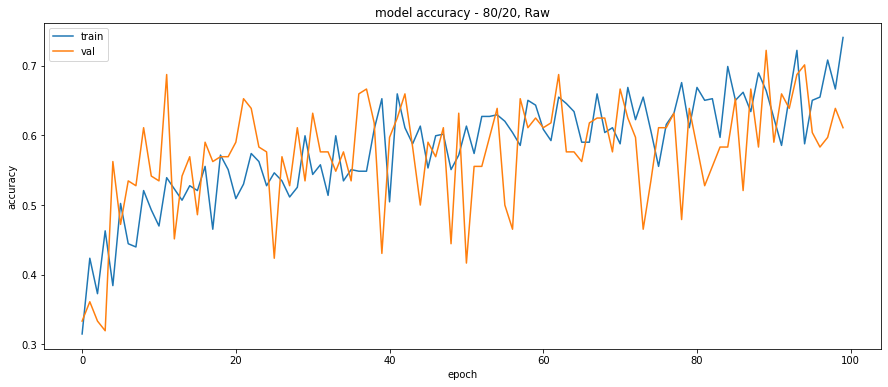

In [149]:
plt.figure(figsize=(15, 6))
plt.plot(history_raw_1.history['acc'])
plt.plot(history_raw_1.history['val_acc'])
plt.title('model accuracy - 80/20, Raw')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

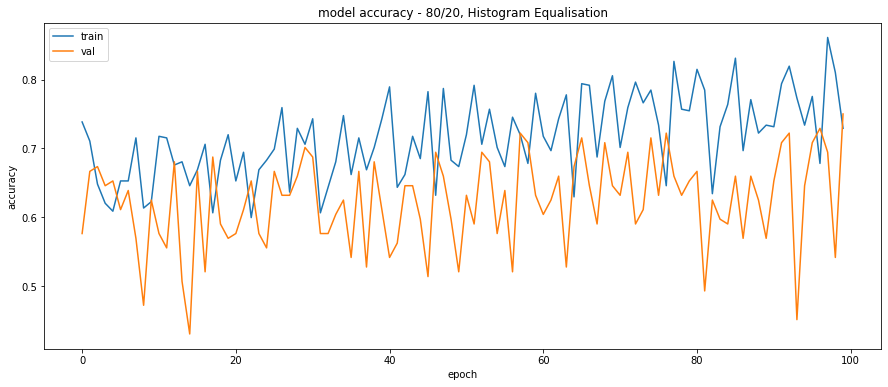

In [150]:
plt.figure(figsize=(15, 6))
plt.plot(history_1_hist.history['acc'])
plt.plot(history_1_hist.history['val_acc'])
plt.title('model accuracy - 80/20, Histogram Equalisation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

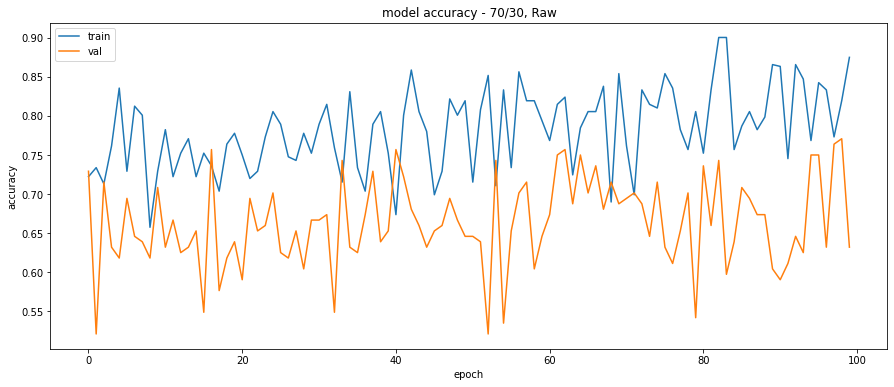

In [151]:
plt.figure(figsize=(15, 6))
plt.plot(history_raw_2.history['acc'])
plt.plot(history_raw_2.history['val_acc'])
plt.title('model accuracy - 70/30, Raw')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

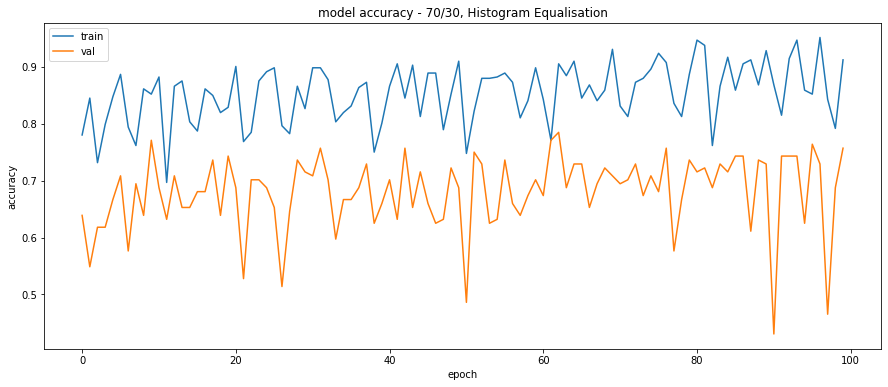

In [152]:
plt.figure(figsize=(15, 6))
plt.plot(history_2_hist.history['acc'])
plt.plot(history_2_hist.history['val_acc'])
plt.title('model accuracy - 70/30, Histogram Equalisation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Summarize history for loss

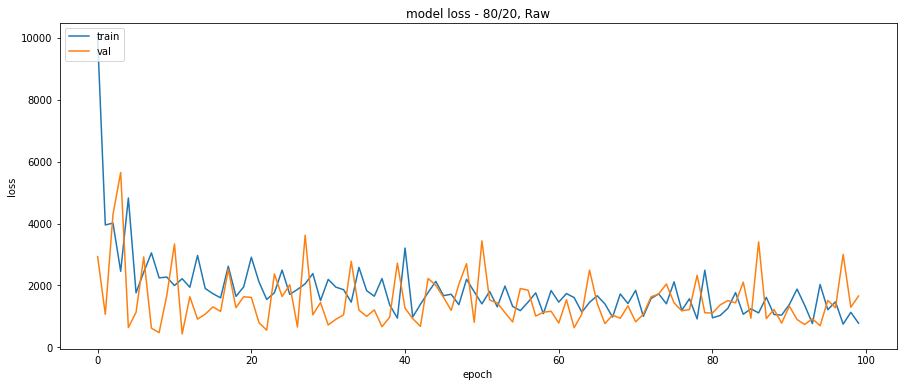

In [153]:
plt.figure(figsize=(15, 6))
plt.plot(history_raw_1.history['loss'])
plt.plot(history_raw_1.history['val_loss'])
plt.title('model loss - 80/20, Raw')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

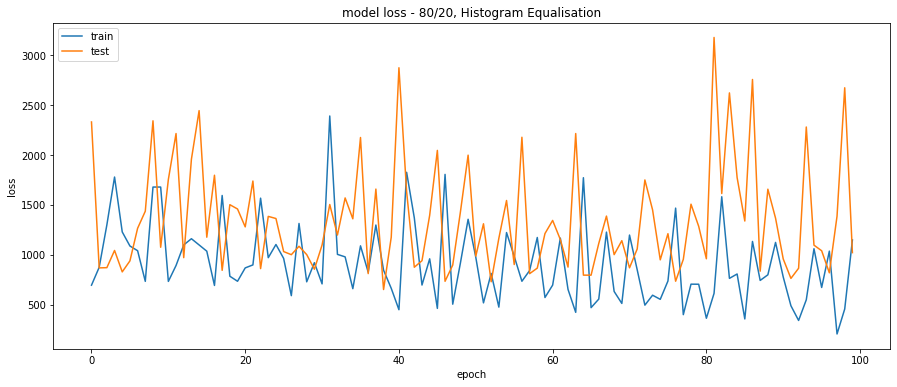

In [154]:
plt.figure(figsize=(15, 6))
plt.plot(history_1_hist.history['loss'])
plt.plot(history_1_hist.history['val_loss'])
plt.title('model loss - 80/20, Histogram Equalisation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

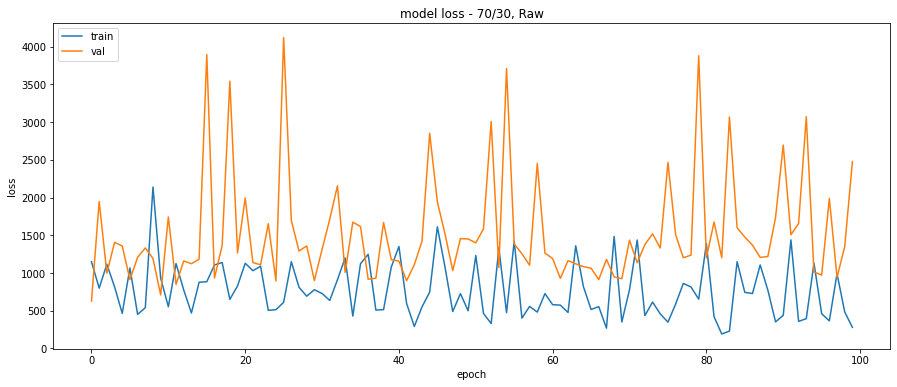

In [155]:
plt.figure(figsize=(15, 6))
plt.plot(history_raw_2.history['loss'])
plt.plot(history_raw_2.history['val_loss'])
plt.title('model loss - 70/30, Raw')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

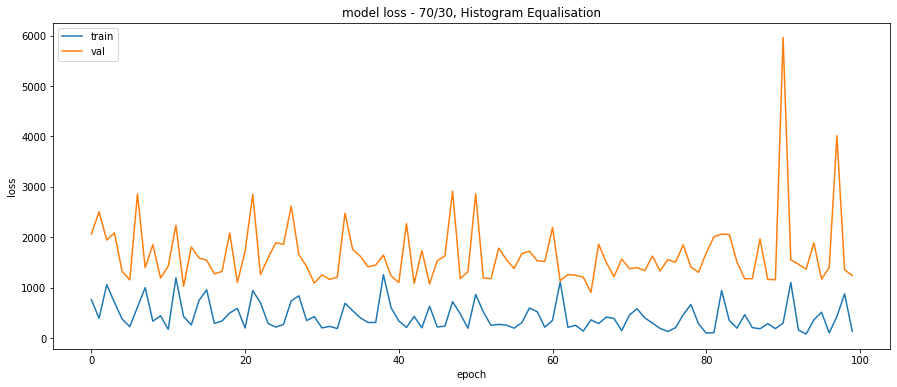

In [156]:
plt.figure(figsize=(15, 6))
plt.plot(history_2_hist.history['loss'])
plt.plot(history_2_hist.history['val_loss'])
plt.title('model loss - 70/30, Histogram Equalisation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Evaluating model on test data

In [168]:
evaluate = model.evaluate(test_images_1, pd.get_dummies(test_labels_1).values)
print(evaluate)

5/5 [==============================] - 0s 39ms/step - loss: 1026.9293 - acc: 0.7055
[1026.9293212890625, 0.7054794430732727]


In [170]:
evaluate = model.evaluate(test_images_1_hist, pd.get_dummies(test_labels_1).values)
print(evaluate)

5/5 [==============================] - 0s 41ms/step - loss: 972.5882 - acc: 0.7671
[972.5881958007812, 0.767123281955719]


In [169]:
evaluate = model.evaluate(test_images_2, pd.get_dummies(test_labels_2).values)
print(evaluate)

7/7 [==============================] - 0s 44ms/step - loss: 832.7932 - acc: 0.7477
[832.7931518554688, 0.747706413269043]


In [171]:
evaluate = model.evaluate(test_images_2_hist, pd.get_dummies(test_labels_2).values)
print(evaluate)

7/7 [==============================] - 0s 46ms/step - loss: 747.9494 - acc: 0.8119
[747.9494018554688, 0.8119266033172607]


#### Testing predictions and the actual label

In [300]:
check_img = test_images_1_hist[14:15]
check_label = test_labels_1[14:15]

predict = model.predict(np.array(check_img))

output = {0: 'accordeon', 1: 'dombyra', 2: 'kobyz'}

print('Actual - ', check_label)
print('Predicted - ', output[np.argmax(predict)])
print(predict)

Actual -  ['accordeon']
Predicted -  kobyz
[[0.         0.11404744 0.88595253]]


### Final Results

#### 80/20, Raw

In [290]:
print(metrics.confusion_matrix(
    [np.argmax(predict) for predict in model.predict(test_images_1)],
    [CATEGORIES.index(label) for label in test_labels_1],
))

[[27  1  1]
 [16 49 13]
 [ 8  4 27]]


In [291]:
print(metrics.classification_report(
    [np.argmax(predict) for predict in model.predict(test_images_1)],
    [CATEGORIES.index(label) for label in test_labels_1],
))

              precision    recall  f1-score   support

           0       0.53      0.93      0.67        29
           1       0.91      0.63      0.74        78
           2       0.66      0.69      0.68        39

    accuracy                           0.71       146
   macro avg       0.70      0.75      0.70       146
weighted avg       0.77      0.71      0.71       146



#### 80/20, Histogram Equalisation

In [292]:
print(metrics.confusion_matrix(
    [np.argmax(predict) for predict in model.predict(test_images_1_hist)],
    [CATEGORIES.index(label) for label in test_labels_1],
))

[[33  1  3]
 [12 50  9]
 [ 6  3 29]]


In [293]:
print(metrics.classification_report(
    [np.argmax(predict) for predict in model.predict(test_images_1_hist)],
    [CATEGORIES.index(label) for label in test_labels_1],
))

              precision    recall  f1-score   support

           0       0.65      0.89      0.75        37
           1       0.93      0.70      0.80        71
           2       0.71      0.76      0.73        38

    accuracy                           0.77       146
   macro avg       0.76      0.79      0.76       146
weighted avg       0.80      0.77      0.77       146



#### 70/30, Raw

In [294]:
print(metrics.confusion_matrix(
    [np.argmax(predict) for predict in model.predict(test_images_2)],
    [CATEGORIES.index(label) for label in test_labels_2],
))

[[49  1  1]
 [18 74 21]
 [ 9  5 40]]


In [295]:
print(metrics.classification_report(
    [np.argmax(predict) for predict in model.predict(test_images_2)],
    [CATEGORIES.index(label) for label in test_labels_2],
))

              precision    recall  f1-score   support

           0       0.64      0.96      0.77        51
           1       0.93      0.65      0.77       113
           2       0.65      0.74      0.69        54

    accuracy                           0.75       218
   macro avg       0.74      0.79      0.74       218
weighted avg       0.79      0.75      0.75       218



#### 70/30, Histogram Equalisation

In [297]:
print(metrics.confusion_matrix(
    [np.argmax(predict) for predict in model.predict(test_images_2_hist)],
    [CATEGORIES.index(label) for label in test_labels_2],
))

[[57  1  3]
 [12 76 15]
 [ 7  3 44]]


In [298]:
print(metrics.classification_report(
    [np.argmax(predict) for predict in model.predict(test_images_2_hist)],
    [CATEGORIES.index(label) for label in test_labels_2],
))

              precision    recall  f1-score   support

           0       0.75      0.93      0.83        61
           1       0.95      0.74      0.83       103
           2       0.71      0.81      0.76        54

    accuracy                           0.81       218
   macro avg       0.80      0.83      0.81       218
weighted avg       0.83      0.81      0.81       218



### Summary

<strong>Model Accuracy <br/></strong>
We can see that histogram equalisation technique gave us much higher results than the ones on the raw data. It's easy-to-notice considering accuracy values at first few epochs are much higher. Maximum hit accuracy is also higher in comparison to raw data. Even though it's worth pointing out that raw data's accuracy does not fluctuate as much, so the values are much more stable. As to the data split ratio, 70/30 turned out to give the biggest perfomance boost in comparison to 80/20. Even more boost than histogram equalisation gives compared to raw data. By now, the best choice would be 70/30 ratio with applied histogram equalisation.

<strong>Model Loss <br/></strong>
In terms of model loss, pretty much the same conclusion could be made. 70/30 ratio with histogram equalisation case is the best option: it has got smallest loss values on average that do not fluctuate as much compared to previous cases. Though they were 2 'outliers' among validation set results around latter epochs, these are just 'exceptions from the rule'.

<strong>Test Data Evaluation <br/></strong>
Results on test dataset totally comply with the previous ones, the logic is all the same here. 70/30 ratio and histogram equalisation, smallest loss and highest accuracy.

<strong>Confusion Matrices and Classification Reports <br/></strong>
In the latter case (70/30, Histogram Classification) we have got the best metrics, and here is why: <br/>
1. Proptionally, the most amount of correct prediction and least amount of wrong ones for each class in confusion matrix.
2. Precision values for each class are highest among all classification reports.
3. Recall scores for each class are highest among all classification reports, except for the 'accordeon' class where 70/30 ratio with raw data report has got slightly better result 0.96 to 0.93.
4. f1-score values for each class are highest among all classification reports.
5. Overall, each score has got the least fluctuation in its values among all classification reports which only proves that it's reliable.